# 15进阶4：大视角问答：RAG如何支持跨文档、跨维度总结

>**本章摘要**
>
>本章我们将为大家介绍如果利用RAG解决统计问题，首先介绍传统RAG在处理统计问题中的缺陷：无法直接处理结构化数据以及缺乏动态计算能力，然后我们介绍了RAG解决统计问题的基本思路，及通过SQL Call和Function Call机制。接下来分别介绍二者，首先介绍SQL的相关概念以及如何构建SQL数据库，然后介绍Text2SQL技术和sql\_tool工具的具体实现。最后介绍Function Call的基本概念，以及如何利用Function Call机制对RAG系统的统计分析能力进行增强。

在进阶3-实战中，我们利用自定义解析PDF Reader和向量库milvus搭建了一个论文问答助手，将rag的能力从纯文本领域扩展到了多模态领域。该论文问答助手的基本架构如下图所示：

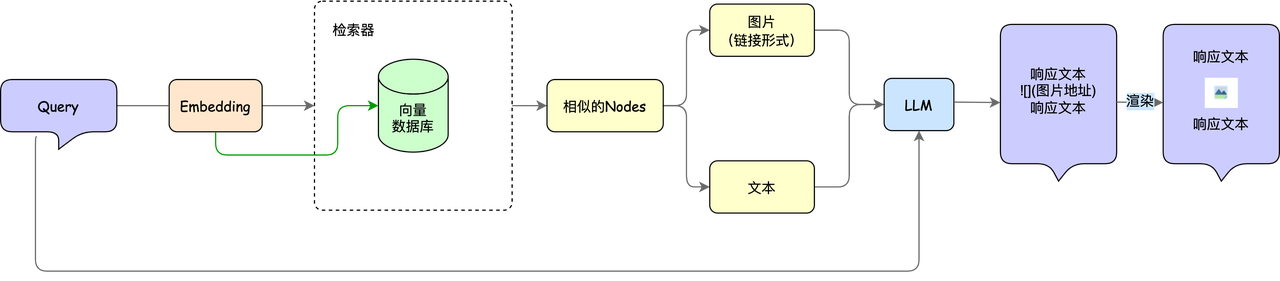

然而如果我们想进一步了解关于这些论文的信息，例如想了解某个论文数据库的论文有多少篇、每年论文的发表数量、增长趋势，又或者更普遍一些，不仅针对论文数据库，假设现在有公司的销售额、利润等相关数据，我们希望了解“过去两年每个月的销售数据和增长趋势是什么？”，“过去三年内，季度利润增长率的变化情况如何？”，对于这类统计问题，仅通过其面介绍的内容就不够了。RAG能否解决这些统计问题？答案是肯定的！那么接下来就让我们来走进带有统计功能的RAG～

## 传统RAG在统计问题中的缺陷🙋

首先让我们来理解“什么是统计问题”。统计问题其实就是与数据有关的各种问题，目的是从数据中找到有用的信息，帮助我们做决策或理解某些现象。比如现在有班级的考试成绩，问班级学生的考试成绩总体总体如何？平均分是多少？哪个科目最难？又或者有相关的销售数据，问月我们的销售额是多少？产品A的销售量是否有所增长？，

介绍完统计的基本概念，让我们仔细思考下传统RAG在统计问题中的缺陷。

在先前的章节中，我们介绍的RAG主要是利用LLM的自然语言理解和生成能力进行基于资料的问答，在进阶3课程中，尽管我们介绍了对表格数据的处理方式，但统计问题中的表格规模远比论文等PDF中的表格更大，无法直接通过图像数据进行解析，而且统计问题中通常会结构化存储海量的数据，例如excel、SQL等。结构化数据统计问题通常涉及具体的数字、表格、数据库等信息，需要精确的计算、推理和模型构建，而传统RAG方法主要依赖于从大量文本数据中检索相关信息并通过生成模型生成答案。具体来说，有如下2个缺陷：

 ### 1. 无法直接处理结构化数据🤔️

结构化数据通常以表格、CSV文件、数据库等形式呈现，而RAG模型的生成和检索模块主要处理的是自然语言文本。虽然传统RAG模型可以检索和生成基于文本的答案，但它并不具备直接解析、理解和操作表格、数据库等结构化数据的能力。例如，如果统计问题涉及到某些特定的数据列运算（如计算均值、标准差、汇总统计等），传统RAG模型可能无法直接从结构化数据中提取所需信息进行计算或推理。

 ### 2. 缺乏动态计算能力🙁

许多结构化数据统计问题需要进行实时的计算和推理，例如通过SQL查询提取数据、利用数学公式进行统计分析。传统的RAG模型只能基于已经检索到的信息生成答案，而无法在检索过程中执行这些复杂的计算任务。例如，在多元回归分析中，传统RAG可能检索到相关文献，但却无法基于输入数据执行回归计算并给出准确结果。从下图可以看到，当我们向普通 RAG 提出一个统计类问题时，会发现它无法执行动态计算，给出了一个错误的答案。

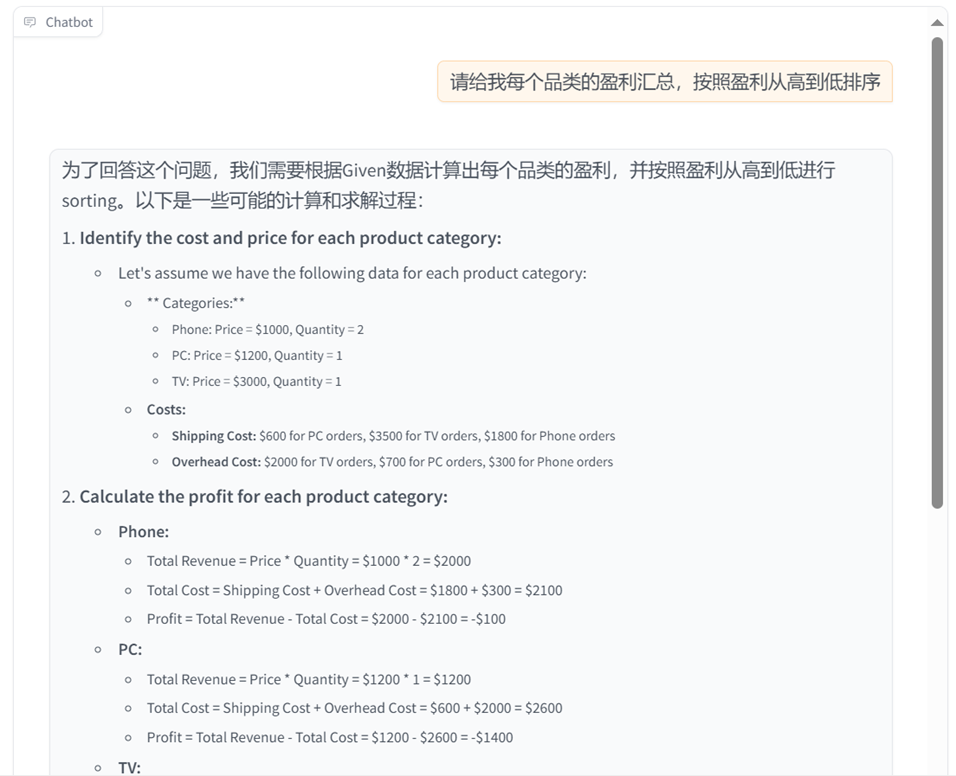


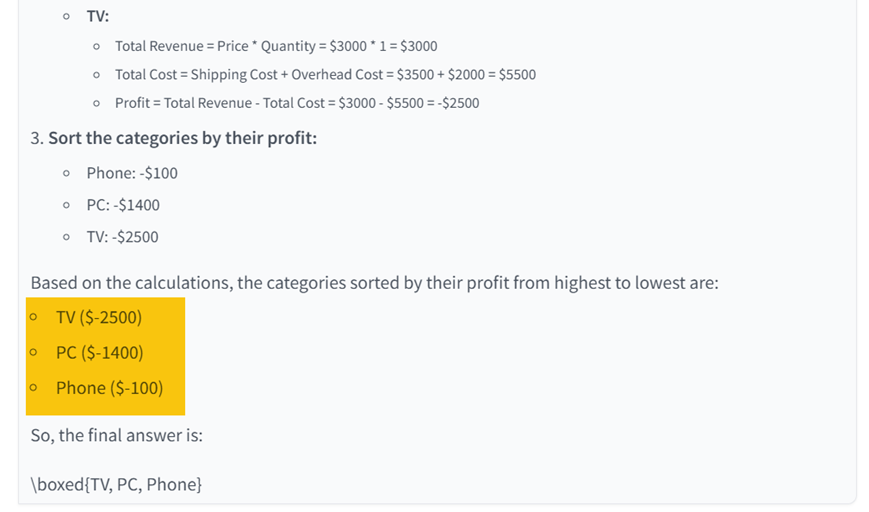

* 正确答案：

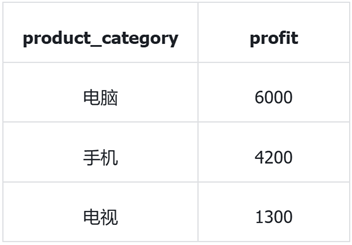

有没有一种办法可以让的RAG也具备处理结构化数据和动态计算的能力？有的兄弟姐妹们！有的！这就是我们本节课要介绍的内容，让RAG具备解决统计问题的能力。

## RAG解决统计问题基本思路✈️

 ### 1. 架构概述

为了更清晰地阐述利用RAG模型解决统计问题的思路，首先我们直接给出带统计分析能力的RAG模型的基本架构，如下图所示。

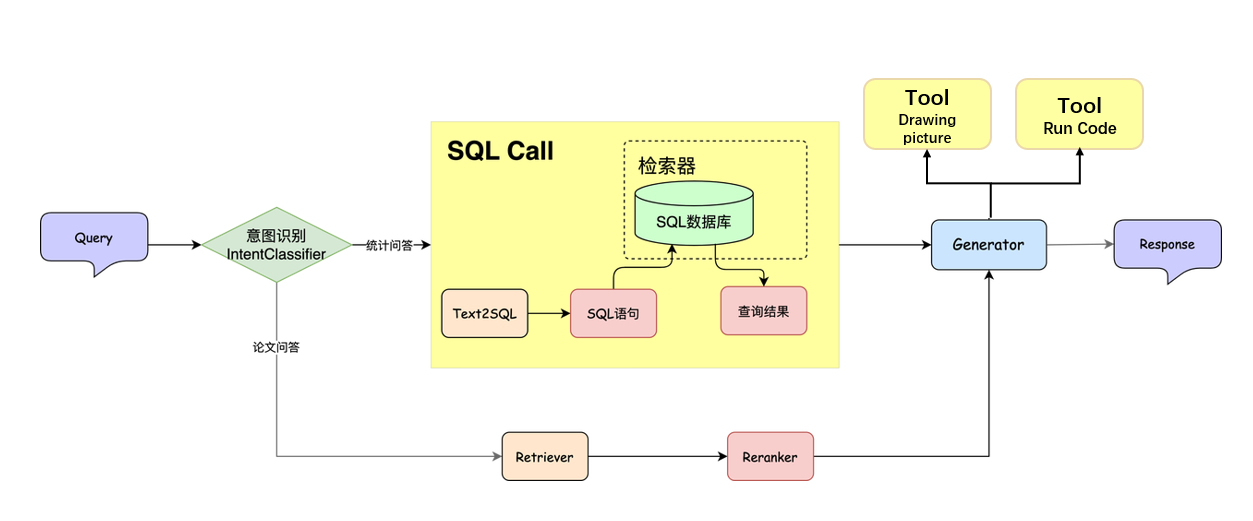

与传统的RAG模型相比，新增了四个关键组件：​**意图识别模块**​、**SQL数据库**​​**和SQL Call。**

* **​意图识别模块：​**将用户自然语言输入映射到预定义意图类别。
* **​SQL数据库：​**将数据写入数据库，便于后续大模型生成SQL语句后进行查找。
* ​**SQL Call**​：将自然语言查询直接映射为可执行的 SQL 语句，并在数据库中查取数据并返回。

此处为了便于理解您可以将Text2SQL和sql\_tool看作是RAG模型中的retriever组件，将SQL数据库看作普通的数据库，这样就能与传统RAG模型的结构保持一致。即依旧是从外部数据源中检索相关信息。检索到的数据与用户的查询一起输入到大模型中，最终生成详细的答案。在下文，我们将介绍SQL数据库、Text2SQL和sql\_tool的具体原理和实现，此处我们首先举几个例子来让您对“利用RAG解决统计问题的基本思路”有个“​**总体上的理解**​”。

结合以上架构图，我们可以讲利用RAG解决的统计分析问题的流程抽象为以下三个步骤：

1.  ​**检索相关数据**​：根据用户的问题，从数据库或数据源中检索出相关的数据。这一步我们需要调用**Text2SQL**和**sql\_tool**工具，得到用于检索的SQL语句，并执行得到检索结果。
2.  ​**计算相关指标**​：对检索到的数据进行统计计算，如增长率、平均值、总和等。这一步我们将上一步检索到的结果输入给大模型，结合用户所提query，即可完成对相应指标的计算。
3.  ​**生成报告**​：根据计算出的指标和相关数据，生成自然语言形式的分析报告。

### 2. 举例说明

接下来我们举两个简单的例子，方便理解上面所说的三个步骤：

#### 案例1：时间序列数据的统计问题

​**问题**​：“过去两年每个月的销售数据和增长趋势是什么？”

​**解决流程**​：

1.  ​**检索相关数据**​：
   1.  使用Text2SQL将用户问题转换为SQL查询语句，例如检索过去两年每月的销售额数据。
   2.  通过sql\_tool执行SQL语句，从数据库中提取相关数据。
2.  ​**计算相关指标**​：
   1.  对检索到的销售额数据进行统计计算，如计算每月的环比增长率、同比增长率，并分析整体趋势。
3.  ​**生成报告**​：
   1.  将计算结果与用户查询结合，生成自然语言形式的分析报告，描述销售数据的趋势和增长情况。

---

#### 案例2：数据汇总与报告生成

​**问题**​：“请给我去年年度财报中的主要财务数据汇总，包括总收入、净利润、成本等。”

​**解决流程**​：

1.  ​**检索相关数据**​：
   1.  使用Text2SQL将用户问题转换为SQL查询语句，例如检索去年财报中的总收入、净利润、成本等财务指标。
   2.  通过sql\_tool执行SQL语句，从数据库中提取相关数据。
2.  ​**计算相关指标**​：
   1.  对检索到的财务数据进行汇总和计算，如计算总收入、净利润的总和或平均值。
3.  ​**生成报告**​：
   1.  将汇总结果与用户查询结合，生成自然语言形式的财务报告，包括数据分析、总结和趋势预测。

## 核心模块原理及实现思路

 ### 1. 意图识别

意图识别是将用户自然语言输入映射到预定义意图类别的关键模块，在客服机器人、智能语音助手、对话式搜索等场景中广泛应用，能够显著提升人机交互的准确性和效率。例如，在智能客服场景中，用户输入“我要退款”需被快速分类至“售后申请”意图，触发自动化工单系统；在语音助手中，“明早八点提醒我开会”需识别为“日程管理”意图并调用日历接口。  

当前主流方法包括基于规则、传统机器学习和大规模预训练模型三类：

1.  **基于规则的方法**

* ​**关键词匹配与正则表达式**​：通过预先定义的关键词、短语和正则模板进行精确匹配，实现对常见意图的快速识别，优点是易于理解与部署，但对多样化表达和同义词扩展支持不足。

2.  **传统机器学习方法**

* ​**支持向量机（SVM）与逻辑回归**​：将文本向量化后，利用SVM、逻辑回归等分类器进行训练，可通过特征工程（如TF-IDF、词性标注）获得较稳定的效果，但对特征设计依赖较高，扩展新意图需大量手工调整。
* ​**决策树、朴素贝叶斯等**​：在小规模数据集上表现良好，但难以捕捉语义上下文信息。

3.  **预训练深度模型**

* ​**BERT及其变体**​：利用大规模语料预训练的Transformer模型，能学习丰富的上下文表示，显著提升长尾意图与小样本意图的识别准确率。
* ​**更大型的大模型**（**如GPT系列**）​：通过少样本示例或提示工程（Prompting）方式，仅需极少标注数据即可完成意图分类任务，同时支持动态扩展新意图类别。

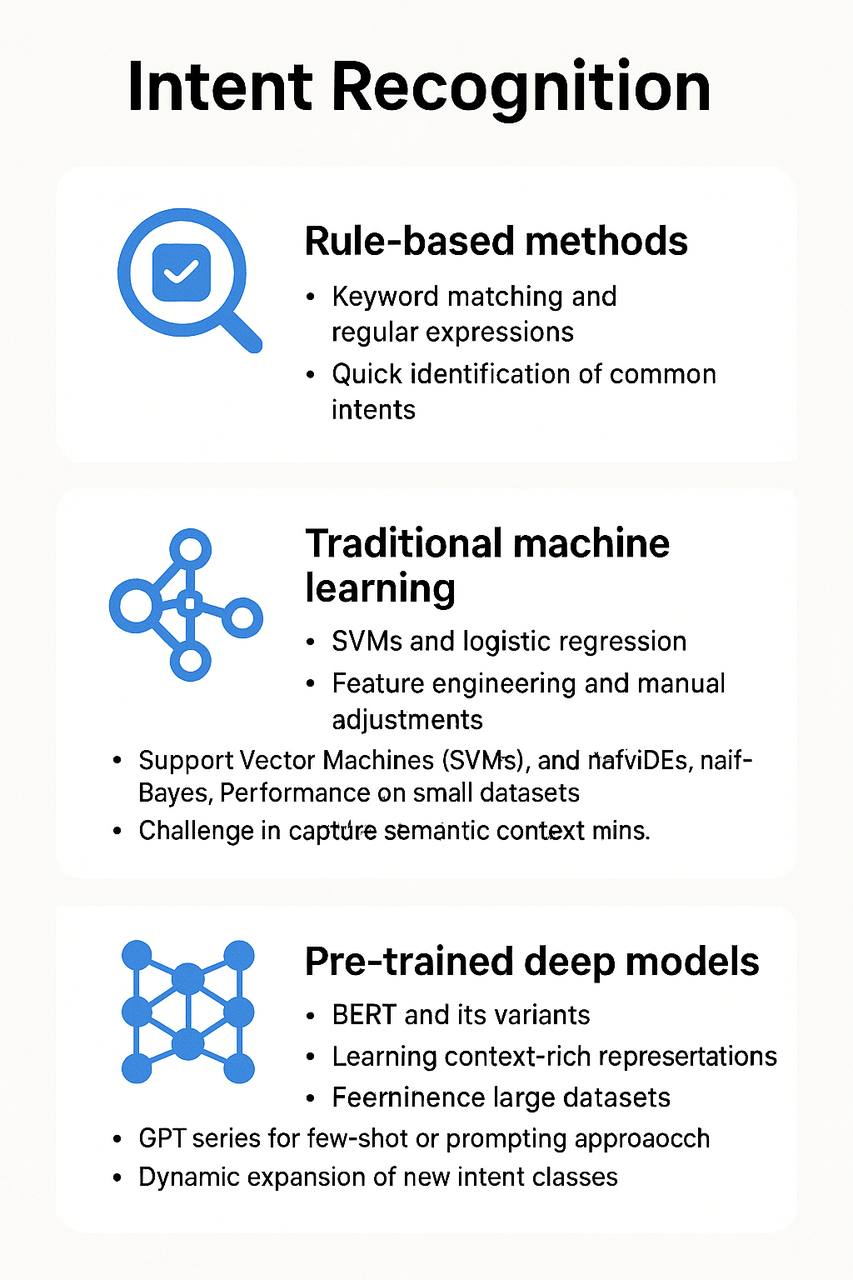

以下是几个不同场景的意图识别示例：

1.  客服场景

   ​**用户输入**：​"我的订单怎么还没发货？" **​识别意图**：查询订单状态
   
   ​**用户输入**：​"我要退换货" **​识别意图​**：申请售后
2.  智能助手场景

   ​**用户输入​**：​"明天北京天气怎么样？" **​识别意图​**：查询天气
   
   ​**用户输入​**：​"定一个明天上午9点的会议" **​识别意图​**：创建日程
3.  电商场景

   ​**用户输入**​："2000元以内的蓝牙耳机推荐" **​识别意图​**：​商品推荐
   
   ​**用户输入**​："怎么用优惠券？" **​识别意图​**：使用优惠
4.  银行/金融场景

   ​**用户输入**​："查一下我的余额" **​识别意图​**：​查询账户余额
   
   ​**用户输入**​："转账给张三500元" **​识别意图​**：发起转账

尽管意图识别技术已经广泛应用，但传统方法在实际场景中仍面临明显局限。基于规则或传统机器学习的方式依赖人工设计，难以应对用户表达的多样性和新意图的快速变化，尤其在处理长尾类别和复杂语义时准确率不足。相比之下，以BERT等为代表的大模型凭借强大的语义建模能力和上下文理解能力，显著提升了意图识别的准确性与鲁棒性，特别适合少样本和高变动的业务场景。因此，基于大模型的意图识别已成为当前主流方案，并正逐步取代传统方法，成为行业发展的关键趋势。

 ### 2. SQL概念及数据库构建🎨
 #### 2.1 基本概念
   
在深入理解SQL之前，这里先对数据库系统的整体生态做一个简要的介绍。数据库按数据组织方式主要分为**关系型**和**非关系型**两大类。


* ​**关系型数据库**​（如 MySQL、PostgreSQL、SQLite）以表格结构管理数据，支持事务和复杂查询，适用于结构化数据。
* **非关系型数据**库根据数据模型又细分为：
  * 文档型：MongoDB，适合灵活存储半结构化数据；
  * 键值型：Redis，主要用于高性能缓存；
  * 向量数据库：FAISS、Milvus，专为高维向量检索设计，应用于推荐系统、搜索引擎等场景。
  
 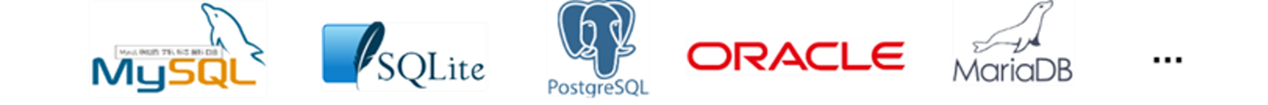

我们接下来的应用主要针对的是关系型数据库，它基于关系模型，由表（table）、行（row）、列（column）组成，采用SQL（结构化查询语言）进行数据操作和查询。相比Excel等电子表格工具在处理中小规模数据时的便捷性，关系型数据库在面对大规模数据时表现出更高的性能与一致性保障。它通过明确的数据结构和组织方式，使得存储、检索、更新和管理数据变得高效、灵活，并能够支持复杂的查询和多表关联操作。

SQL（Structured Query Language，结构化查询语言）是一种​**专门用于管理和操作关系型数据库的标准编程语言**​。它通过一系列声明性语句，使得用户能够在数据库中执行数据查询、数据插入、数据更新、数据删除等操作，并支持创建和管理数据库结构，如表、视图、索引等。SQL语言的设计目标是简化对数据库的操作，使得用户不必关心数据存储的具体细节，能够专注于如何有效地管理和查询数据。下面这句SQL语言的含义是筛选工资大于5000元的员工。



```SQL
SELECT name FROM employees WHERE salary > 5000;
```

#### 2.2 构建SQL数据库

接下来我们从一个简单的例子出发，讲解如何构建SQL数据库：

假设现在有一组电商平台的相关数据，经过统计我们得到了每个订单的相关信息。包含以下列：`order_id`，`product_id`，`product_category`，`product_price`，`quantity`，`cost_price`，`order_date`。表格中的内容为：

| **order\_id** | **product\_id** | **product\_category** | **product\_price** | **quantity** | **cost\_price** | **order\_date** |
| --------------------- | ----------------------- | ----------------------------- | -------------------------- | -------------------- | ----------------------- | ----------------------- |
| 1                   | 101                   | 手机                        | 1000                     | 2                  | 600                   | 2025/1/1              |
| 2                   | 102                   | 手机                        | 1200                     | 1                  | 700                   | 2025/1/2              |
| 3                   | 103                   | 电脑                        | 5000                     | 1                  | 3500                  | 2025/1/3              |
| 4                   | 104                   | 电脑                        | 4500                     | 3                  | 3000                  | 2025/1/4              |
| 5                   | 105                   | 电视                        | 3000                     | 1                  | 1800                  | 2025/1/5              |
| 6                   | 106                   | 电视                        | 3500                     | 2                  | 2000                  | 2025/1/6              |

则我们可以通过以下流程完成数据库的创建：

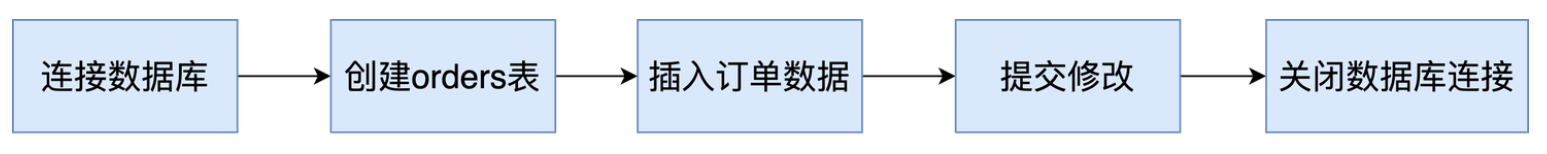

可以利用如下python代码实现上述流程：

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter15/%E8%BF%9B%E9%98%B64%EF%BC%9A%E5%88%A9%E7%94%A8RAG%E8%A7%A3%E5%86%B3%E7%BB%9F%E8%AE%A1%E9%97%AE%E9%A2%98.py#L1)

In [ ]:
import sqlite3  # 导入sqlite3模块，用于操作SQLite数据库

# 连接到数据库
# 如果数据库文件'ecommerce.db'不存在，SQLite会自动创建一个新的数据库文件
conn = sqlite3.connect('ecommerce.db')  
cursor = conn.cursor()  # 创建一个游标对象，用于执行SQL操作

# 创建 orders 表
# 使用CREATE TABLE语句创建一个新的表，表名为 orders
# IF NOT EXISTS 子句确保如果表已经存在，不会重复创建
cursor.execute('''
CREATE TABLE IF NOT EXISTS orders (
    order_id INT PRIMARY KEY, 
    product_id INT,            
    product_category TEXT,     
    product_price DECIMAL(10, 2),  
    quantity INT,              
    cost_price DECIMAL(10, 2),  
    order_date DATE            
)
''')
# 订单ID，作为主键，确保每个订单有唯一标识
# 产品ID
# 产品类别（例如，手机、电脑、电视等）
# 产品价格，保留2位小数
# 购买数量
# 产品成本价格，保留2位小数
# 订单日期

# 插入数据
# 定义一个包含多个订单的列表，每个订单的相关信息（如订单ID、产品ID、价格等）
data = [
    [1, 101, "手机", 1000, 2, 600, "2025/1/1"],
    [2, 102, "手机", 1200, 1, 700, "2025/1/2"],
    [3, 103, "电脑", 5000, 1, 3500, "2025/1/3"],
    [4, 104, "电脑", 4500, 3, 3000, "2025/1/4"],
    [5, 105, "电视", 3000, 1, 1800, "2025/1/5"],
    [6, 106, "电视", 3500, 2, 2000, "2025/1/6"]
]

# 执行插入操作，将每一条数据插入到 'orders' 表中
# cursor.executemany() 方法用于执行多个INSERT语句，批量插入数据
cursor.executemany('''
INSERT INTO orders (order_id, product_id, product_category, product_price, quantity, cost_price, order_date)
VALUES (?, ?, ?, ?, ?, ?, ?)
''', data)

# 提交更改
# 使用 conn.commit() 提交事务，将所有插入操作保存到数据库中
conn.commit()

# 关闭连接
# 在完成操作后，关闭数据库连接，释放资源
conn.close()

接下来，我们使用 SQL 浏览工具来查看一下数据库文件 `ecommerce.db` 的具体内容：

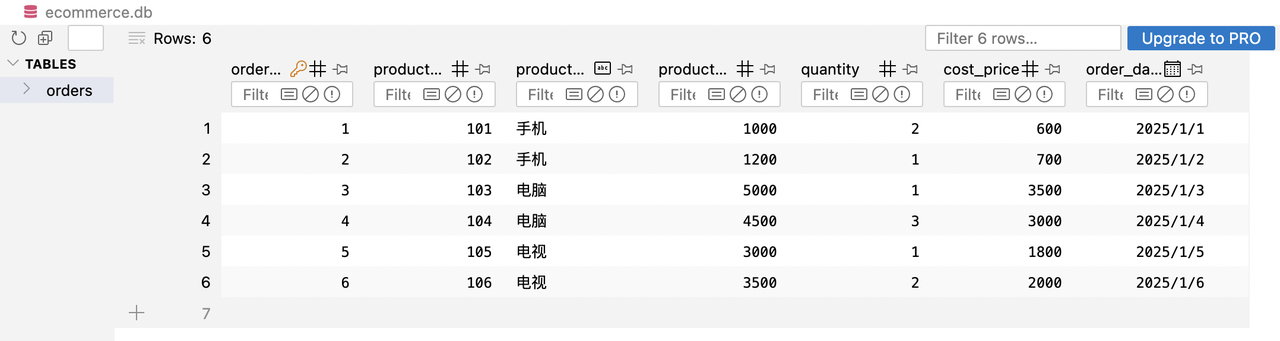

可见我们已经成功创建order表格并将数据成功写入数据库，接下来我们将用这张表格来进行数据库的查询。

 ### 3. SQL Call ✨

在介绍SQL Call之前，我们先介绍下SQL Call的核心模块：Text2SQL。

Text2SQL是一种自然语言处理（NLP）技术，旨在将人类的自然语言查询转化为 SQL 查询语句。通过这种技术，用户无需学习 SQL 语言的语法或结构，直接用自然语言提出问题，就能自动生成相应的 SQL 查询。Text2SQL 系统通常依赖于深度学习模型和自然语言处理技术。它的主要工作流程如下：

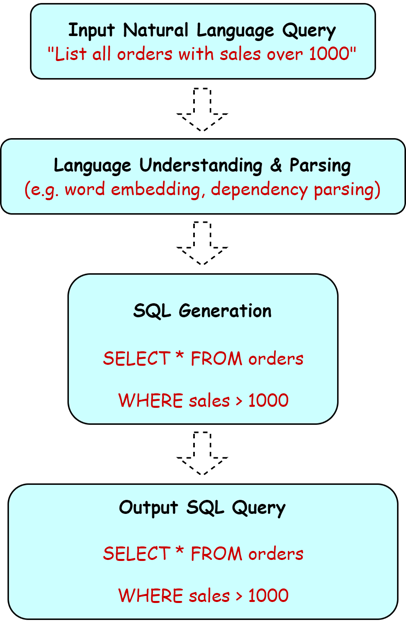

1.  ​**输入自然语言查询**​： 用户通过文本输入查询，例如“列出所有销售额超过1000的订单”。
2.  ​**语言理解与解析**​： 系统通过自然语言理解技术（如词嵌入、依赖解析等）理解用户意图、识别查询中的关键实体和关系，例如识别出“销售额”和“订单”是查询的核心内容。
3.  ​**SQL 生成**​： 根据语言理解的结果，系统自动生成对应的 SQL 查询语句，确保语法正确并与数据库结构相匹配。
4.  ​**输出 SQL 查询**​： 最终，系统返回一个正确的 SQL 查询语句，用户可以直接用这个语句在数据库中执行。

例如还是以上面电商平台的数据为例，输入query为“请给我每个品类的盈利汇总，按照盈利从高到低排序”，我们就可以通过Text2SQL得到对应的SQL查询语句：



```SQL
SELECT product_category,
         SUM(product_price * quantity) - SUM(cost_price * quantity) AS profit 
FROM orders 
GROUP BY product_category 
ORDER BY profit DESC;
```



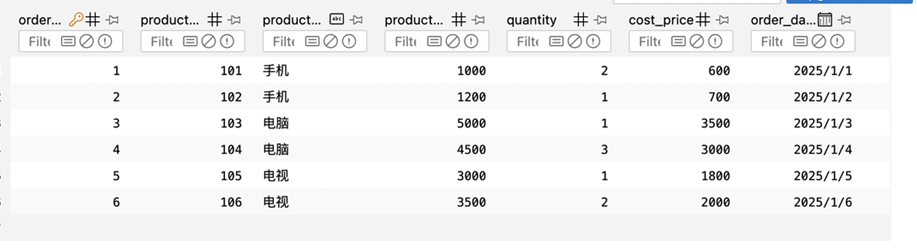

有了 Text2SQL 这一核心功能作为基础，SQL-call 进一步实现了从自然语言理解、SQL 生成，到自动执行查询与结果反馈的全流程闭环，让大模型不仅能“写出”SQL，还能真正“用起来”。

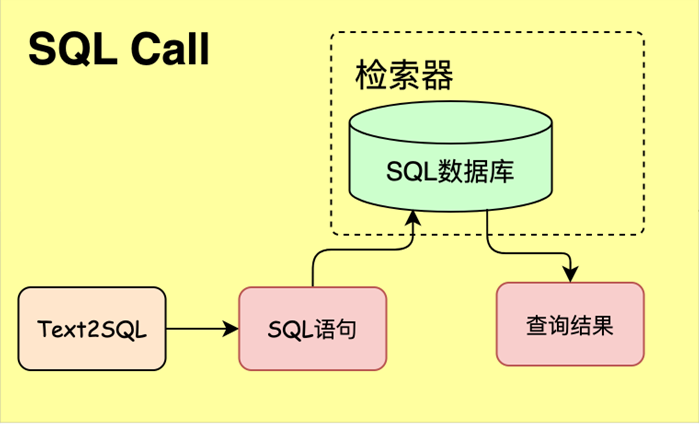

SQL-call 利用大模型（LLM）的函数调用接口，将自然语言查询直接映射为可执行的 SQL 语句，并在数据库中查取或更新数据，实现结构化问答能力。在传统 RAG 主要处理非结构化文本检索的基础上，SQL-call 打通了大模型与数据库的交互通路，使模型能够“调工具”调用数据库获得实时、准确的结构化数据信息，从而进行更精准和复杂的下游问答任务。SQL-call 的应用场景非常广泛，例如：

* ​**ChatBI 与数据平台助手**​：如腾讯云 ChatBI，通过意图识别与 SQL-call 将用户的自然语言分析请求自动转为 SQL 查询，并以图表、报表形式呈现，极大降低了 BI 使用门槛。
* ​**智能客服与对话机器人**​：在智能客服中，用户提出如“查询订单状态”或“退货进度”等问题时，系统通过 SQL-call 查询数据库中的相关信息，并将结果转化为自然语言回复给用户，如“您的订单已发货，预计三天内送达”。这样不仅提高了响应速度，还实现了业务流程的自动化。

SQL-call 系统包含三个核心模块：

1.  Text2SQL：将自然语言query转换为SQL语句
2.  SQL数据库：存储结构化数据
3.  SQL Manager（检索器）：执行SQL并返回查询结果

支持SQL call的数据库类型有：

* 关系型数据库：MySQL、PostgreSQL、SQLite、SQL Server、Oracle
* 分布式数据库：CockroachDB、TiDB 等
  
借助意图识别模块和 SQL Call模块，我们已经具备了在传统 RAG 框架基础上支持 SQL 相关问答的核心能力。具体的系统搭建流程将在后续的实战课程中进行详细讲解。

#### **将SQL Call加入到RAG中**

我们可以将 SQL 的统计问答能力引入到RAG中，具体流程为用户输入query，经过意图识别模块，决定是否调用 SQL Call 还是只使用传统 RAG。

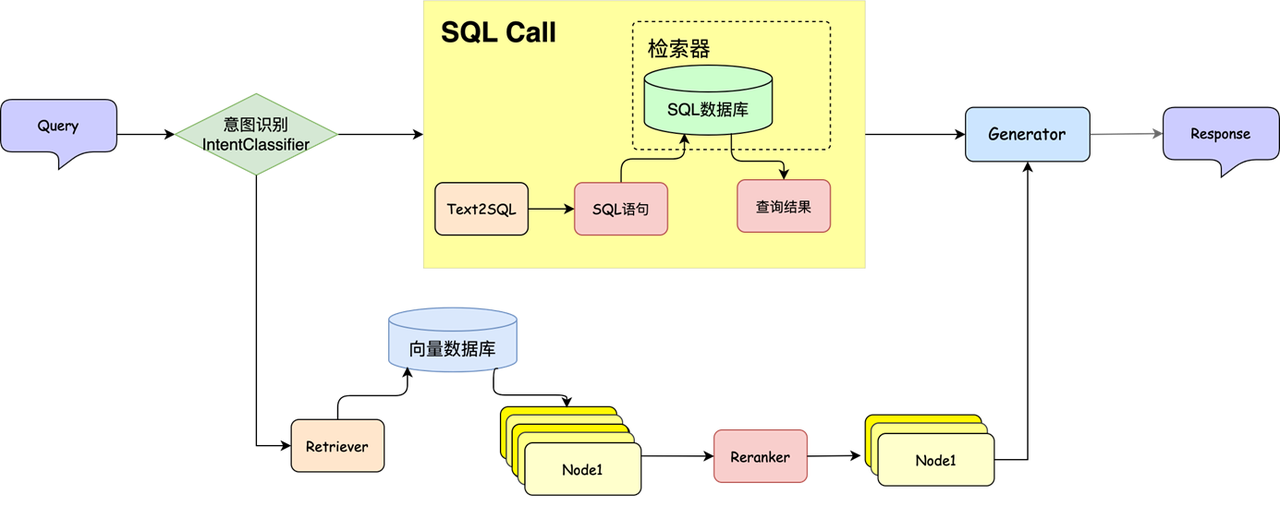

🔍 对于 SQL 分支：

1.  根据用户的请求将 query 转化成相应的 SQL 查询语句
2.  调用 SQL 语句得到查询结果
3.  将查询结果返回给 LLM

从知识库中提取信息到数据库

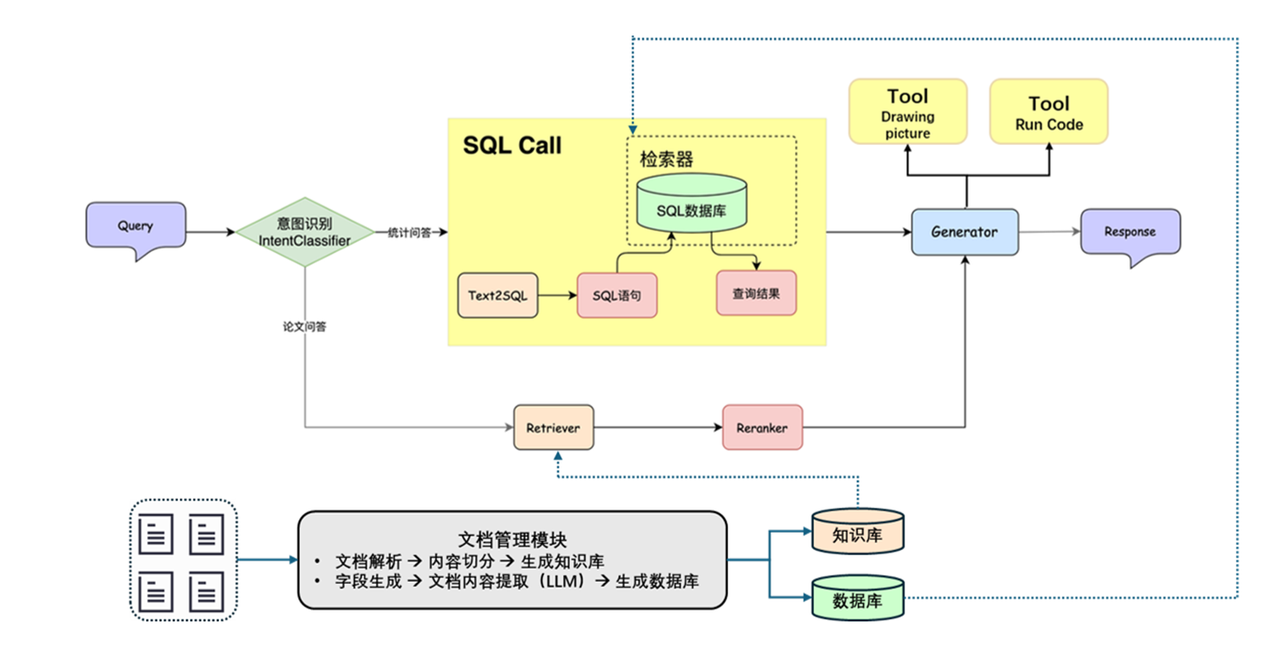

## 统计分析能力增强

 ### 1. ChatBI 📊

#### ChatBI 是什么？

ChatBI（Chat-based Business Intelligence），即 聊天式商业智能，是一种结合了自然语言处理（NLP）、大语言模型（LLM）与数据分析能力的智能系统，允许用户 通过自然语言与数据对话，像和人聊天一样完成数据查询、报表生成、分析洞察等任务。以DataFocus BI为例，它“检索式BI”为特色，提供了丰富的图表样式和简洁的交互界面，支持SQL自由和数据平等的理念。

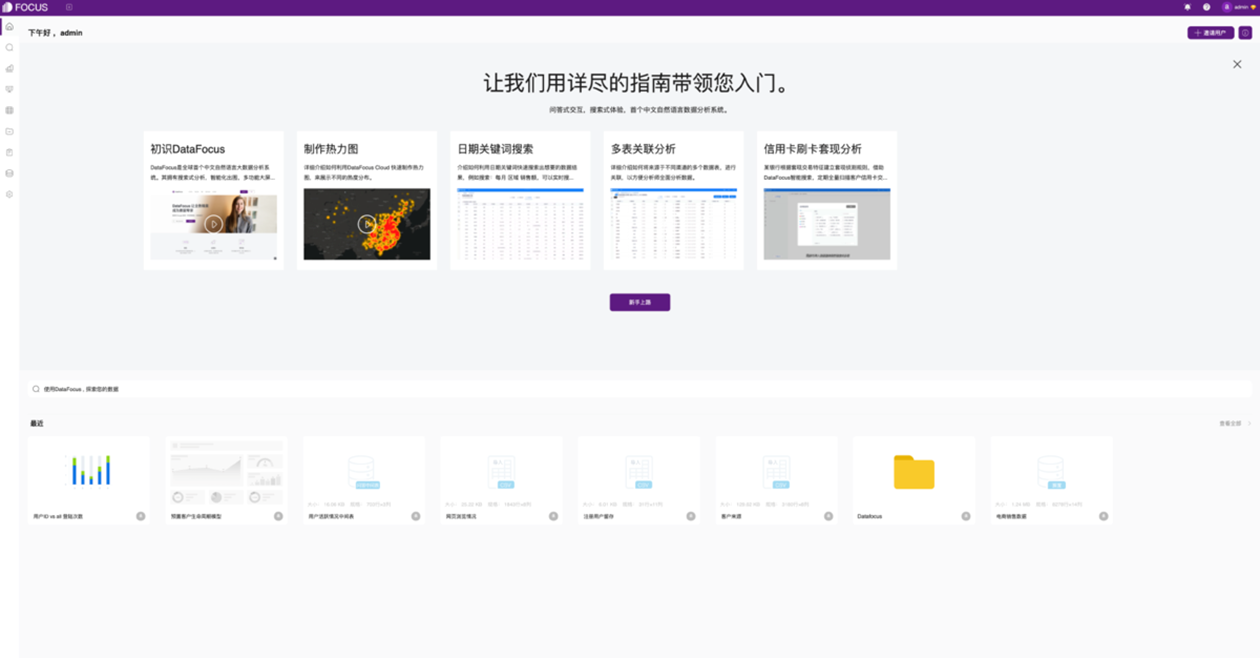

#### ChatBI 架构设计图

我们基于 ChatBI 的理念，设计了一种融合 SQL 查询与图表绘制能力的 RAG 系统。

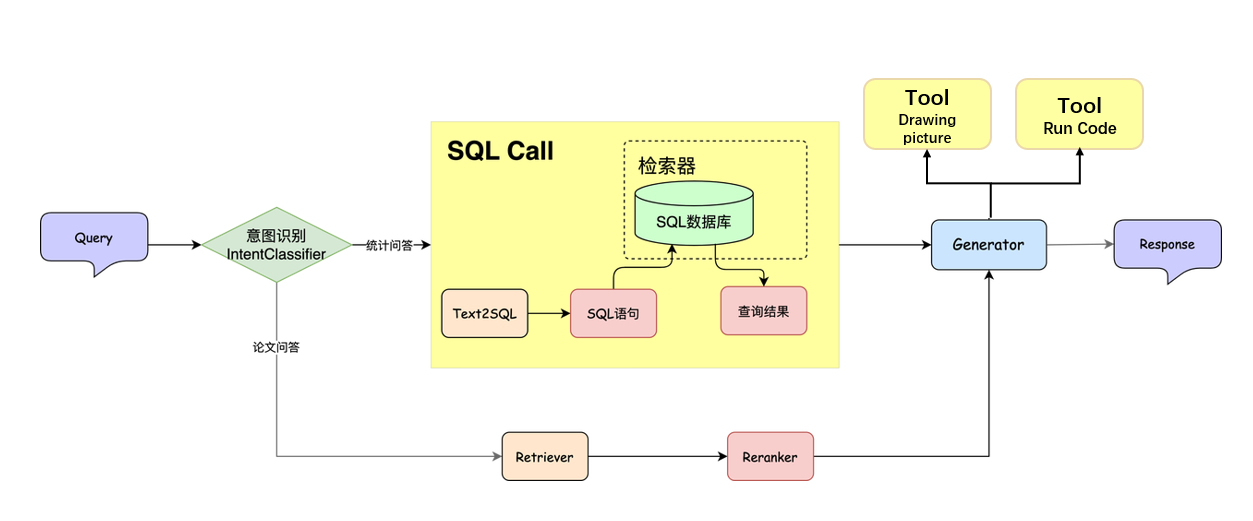

整体流程是：用户提出问题后，通过意图识别后，系统首先使用 Text2SQL 工具将自然语言转化为对应的 SQL 语句并执行查询；接着将查询结果交给大语言模型（LLM）处理，并为其注册好绘图函数，使得模型能够基于数据结果调用绘图工具，自动生成相应图表。这样，系统就能实现数据分析与可视化的一体化输出。

 ### 2. Function Call 🚀

#### Function Call基本概念

前面我们通过SQL Call技术（即构建数据库、Text2SQL以及SQL查询三个步骤），成功使RAG具备了处理结构化数据的统计能力，解决了传统RAG在统计问题中的第一个缺陷，对于RAG缺乏动态计算能力的问题，我们是否有办法能解决呢？同时上述SQL查询虽然可以执行一些简单的数学运算和逻辑运算，但实际中您可能会面临非常复杂的数学计算甚至建模问题，这类问题就无法通过SQL直接执行了。针对这些难点，我们可以引入Function Call机制为系统赋予高阶的统计分析能力。接下来我们将首先介绍Function Call的基本概念和使用，然后介绍如何在RAG中使用Function Call机制。

当你询问任意大模型 「北京目前天气如何」，一般都会返回些乱回答的内容，因为它们的训练资料都有一个截止日期，这些最新的信息对它们是不可见的。针对这种情况，Function Call应运而生，Function Call（函数调用）是指在编程中执行一个已经定义的函数，以便运行该函数中包含的代码逻辑。在上述例子中，我们可以定义一个天气API，当用户询问时，调用天气API就可以拿到最新的天气资讯回答用户的问题，提升用户的使用体验。其实上文中的sql\_tool也是一种基于Function Call的外部函数调用。

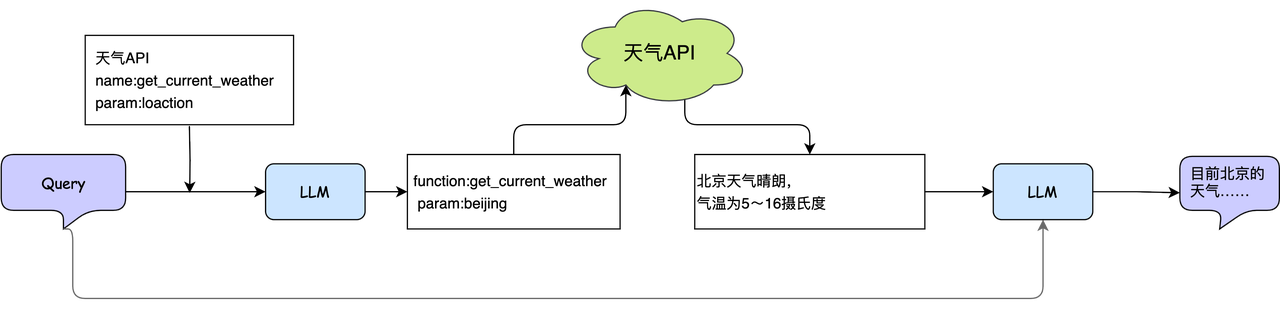

Function Call的原理和我们在编程中使用函数的原理是一样的，我们告诉大模型现在有若干个函数可以调用，每个函数对应哪种能力，入参和出参分别是什么，这样大模型就可以根据需求给出一个函数调用的参数列表。当然函数调用及出入参解析是需要通过传统编程实现的，这时使用框架可以帮助您节约这部分代码的开发，直接输入可用方法即可实现Function Call。下面简单讲一个例子带大家深入体会一下Function Call，同样以天气查询案例为例，现在有这样一个天气查询API，它接收地点为参数，返回对应位置的天气情况，将其以JSON的形式表示为：

```json
{
      "type": "function",
      "function": {
          "name": "get_current_weather",
          "parameters": {
              "type": "object",
              "properties": {
                  "location": {"type": "string"}
              }
          }
      }
  }
```



我们把这个API描述和用户Query传给大模型，当大模型接收到与天气相关的查询时会根据用户输入和API参数相关信息返回一个API调用信息：



```json
{
    "id": "call_12345xyz",
    "type": "function",
    "function": { "name": "get_current_weather", "arguments": "{'location':'Beijing'}" }
 }
```



上述json中清晰的表达了接下来系统需要调用名为“get\_current\_weather”的函数，入参为“location=Beijing”。函数调用结束后您会得到一个这样的结果：



```json
{
    "status":"1",
    "info":[
        {
            "province":"北京",
            "city":"北京市",
            "weather":"晴",
            "temperature":"6",
            "winddirection":"西北",
            "windpower":"≤3",
            "humidity":"15",
            "reporttime":"2025-01-03 15:00:13"
        }
    ]
}
```



针对上述API返回的结果，您需要通过传统编程进行有效数据提取后将其与用户查询一同传入大模型，模型会返回北京天气的自然语言描述。对于用户而言，Function Call通常是不可见的，因此看起来像是大模型完成了一次天气查询和解答，同样我们可以将其应用至当前的统计分析中。

#### Function Call 中的函数定义和使用方式

以绘图为例，我们定义了一个使用 Matplotlib 绘制柱状图的函数，通过装饰器@fc\_register(“tool”)将其注册成为可以调用的工具。



In [ ]:
@fc_register("tool")
def plot_bar_chart(subjects, values):
    """
    Plot a bar chart using Matplotlib.

    Args:
        subjects (List[str]): A list of subject names.
        values (List[float]): A list of values corresponding to each subject.
    """
    
    ...

    plt.show()


❗ 注意：在撰写函数时，一定要在函数下方加上注释，格式如上（函数下方红色部分）。在大模型调用该函数时，将通过函数的描述（如上面的Plot a bar chart using Matplotlib.）以及参数的表述（即subjects (List[str])和  values (List[float]) ），决定何时调用以及传入参数。下面为LazyLLM中Function Call的函数简单使用方式。


In [ ]:
from lazyllm.tools import FunctionCallAgent

llm = lazyllm.OnlineChatModule(source="sensenova", model="...")
tools = ["plot_bar_chart"]
query = "...."
fc = FunctionCallAgent(llm, tools)
ret = fc(query)


#### 常用的 Function Call 算法

|         | **Function Call**                                                  | **ReAct**（**Reason + Act**）                                      | **PlanAndSolve**                                                                                                               | **ReWOO**（​**ReAct with Working Memory​**）                 |
| ---------- | -------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------- |
| 工作流程 | 最大循环次数内循环：<br>- 试参调用工具；<br>- 观察工具输出，完成任务就结束循环。 | 最大循环次数内循环：<br>- 思考；<br>- 试参调用工具；<br>- 观察工具输出，完成任务就结束循环。 | 最大循环次数内循环：<br>- （重）计划并分解任务；<br>- 调用工具解处理当前前子任务；<br>- 观察工具输出，确定是否完成子任务，完成整个任务就结束循环 | - 计划并分解任务；<br>- 调用工具逐步解决所有子任务<br>- 综合所有步骤结果进行反馈 |
| 工作特点 | 简单直接，思考过程不可见                                                 | 引入思考环节，思考可见                                                           | 强调任务的分解和任务的动态调整                                                                                                       | 强调整体规划和综合反馈                                                   |

📌 更多有关 Function Call 的内容与详细实战操作，请关注后续 RAG 教程。

#### Function Call 流程展示

示例问题：请问汤姆的同桌的姐姐的家乡明天的气温怎样？

**Plan：大模型把问题分解成若干步骤**



```text
Q1：汤姆的同桌是谁？得到答案 A1
Q2：A1 的姐姐是谁？得到答案 A2
Q3：A2 的家乡是哪个城市？得到答案 A3
Q4：A3 明天的气温是多少？得到最终答案 A4
```



下面为LazyLLM中的简单示例流程代码。



In [ ]:
def get_sister_name(name: str) -> str: ...
def get_hometown(name: str) -> str: ...
def get_deskmate(name: str) -> str: ...
def get_tomorrow_temperature(city: str) -> Optional[float]: ...

agent = PlanAndSolveAgent(llm=TrainableModule("internlm2-chat-7b").start(),
                          tools=[get_sister_name, get_hometown, get_deskmate,    
                                 get_tomorrow_temperature])
ret = agent("请问汤姆的同桌的姐姐的家乡明天的气温怎样？")



**Solve：大模型从工具列表中选择合适的工具解答问题**

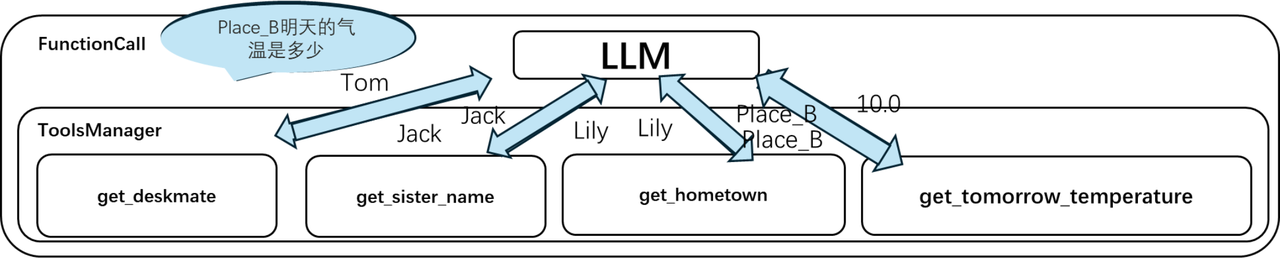

在得到问题后，大模型会把问题分成若干步骤，然后根据需要调用合适的工具。



#### 常用可视化工具

| **工具包**    | **核心能力**                                                                         | **适用场景**                               | **优点**                                             | **缺点**                           |
| --------------------- | -------------------------------------------------------------------------------------------- | -------------------------------------------------- | ------------------------------------------------------------ | ------------------------------------------ |
| Matplotlib          | - 基础 2D/3D 绘图- 高度自定义图表细节<br>- 支持多种图表类型（折线、柱状、散点、等高线等）      | - 科学计算<br>- 论文/出版物图表<br>- 底层绘图需求        | - 高度灵活<br>- 兼容性强（几乎所有库都基于它）                 | - API 较底层，代码冗长<br>- 默认样式较简陋   |
| Seaborn             | - 统计可视化（分布、回归、分类等）<br>- 高级封装（箱线图、热力图、小提琴图等）<br>- 默认美观的样式 | - 数据分布分析<br>- 统计建模可视化<br>- 快速生成美观图表 | - 代码简洁<br>- 内置统计功能<br>- 默认样式优雅                     | - 依赖 Matplotlib <br>- 自定义能力较弱       |
| Plotly              | - 交互式可视化（缩放、悬停、点击等）<br>- 支持动态/3D 图表<br>- 可导出为 HTML/Web 应用             | - 交互式仪表盘<br>- Web 应用嵌入<br>- 动态数据展示       | - 强大的交互性<br>- 支持复杂图表（如地理地图）<br>- 与 Dash 集成   | - 学习曲线较陡<br>- 不适合静态报告           |
| Bokeh               | - 交互式可视化（适合大规模数据）<br>- 支持流数据更新<br>- 可嵌入 Web 应用                          | - 实时数据监控<br>- 大规模数据集交互<br>- Web 应用开发   | - 高性能（适合大数据）<br>- 灵活的交互设计                     | - 文档较分散<br>- 默认样式一般               |
| **Pyecharts** | - 基于 ECharts的交互式图表<br>- 支持动态/3D/地理地图<br>- 可嵌入 Web/Jupyter                       | - 中文环境友好<br>- 企业级仪表盘<br>- 复杂交互需求       | - 图表类型丰富（如桑基图、日历图）<br>- 配置灵活<br>- 中文文档完善 | - 依赖 JavaScript 渲染<br>- 非纯 Python 生态 |

 ### 3. 在RAG中使用 Function Call 🏄

这里我们通过一个简单的例子为大家讲解如何通过Function Call实现数值计算，以此来提升RAG系统的动态计算能力。假设我们要分析某公司过去 12 个月的营收数据，那么在第一步骤中我们通过SQL转写与查询，得到了过去12个月的营收数据如下：

| 月份               | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10  | 11  | 12  |
| -------------------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 营收（单位：万元） | 200 | 210 | 230 | 190 | 250 | 220 | 240 | 200 | 210 | 220 | 250 | 230 |

我们可以通过prompt对大模型进行指示，告知目前有均值计算方法可以了解一段时间内的整体水平，以及计算方差的函数可以帮助了解数据在一段时间内的波动性，方差越小波动性越小，并将各个函数对应的入参信息进行标注，如下所示（您可以自定义函数说明格式）：



```json
[{
      "type": "function",
      "function": {
          "name": "get_mean",
          "description": "计算输入值的平均值，可以了解一段时间内的整体水平",
          "parameters": {
              "type": "object",
              "properties": {
                  "data": {"type": "list"}
              }
          }
      }
  },
  {
      "type": "function",
      "function": {
          "name": "get_variance",
          "description": "计算数据方差，了解数据在一段时间内的波动性，方差越小波动性越小",
          "parameters": {
              "type": "object",
              "properties": {
                  "data": {"type": "list"}
              }
          }
      }
  }]
```



当大模型接收到这些数据后选择了其中的某个分析方法，就可以调用对应的函数进行均值（或方差）计算，进一步丰富统计结果的描述。均值方差是最基础的分析方式，您也可以根据需求设计一些复杂的算子进行计算能力增强。

 ### 4. 绘制图表📉

观察上述12月营收表，我们可以发现这个表非常适合绘制折线图，可以更直观的向用户展示12个月以来的营收趋势。已知Function Call可以实现任意外部函数的调用，即系统可以实现图表绘制，那么我们就可以实现一个简单的图表绘制程序对SQL查询数据进行折线图、饼图等的绘制，给到用户更直观清晰的答复。整体的思路如下图：

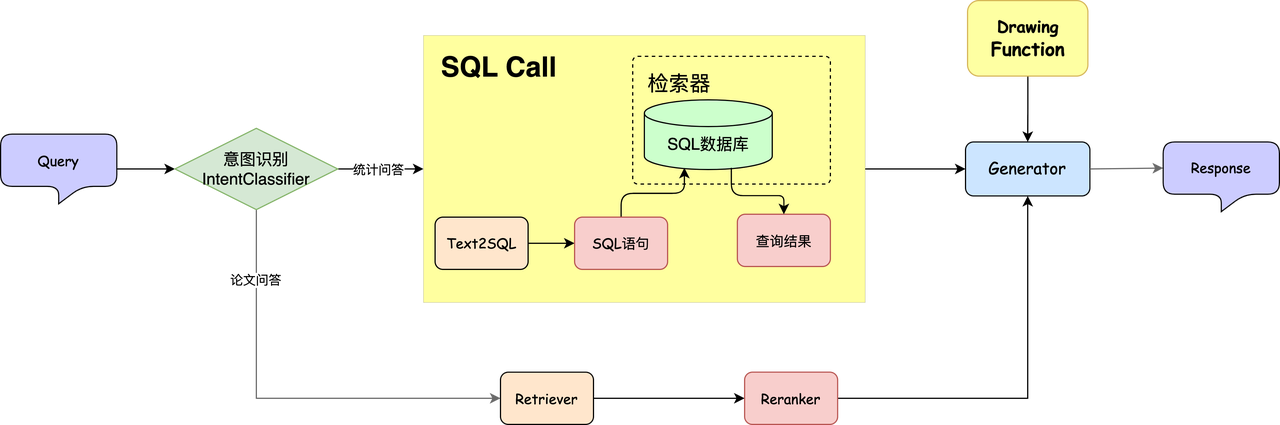

首先我们提出一个query，输入给Text2SQL工具转化成SQL语句，然后得到查询结果，查询结果送给LLM，并预先注册好Drawing Function，这样LLM就能结合查询结果和画图的工具，绘制出来相应的图像，输出图像的形式如下图所示，可以看到与纯文字相比，图像的方式更加清晰明了。

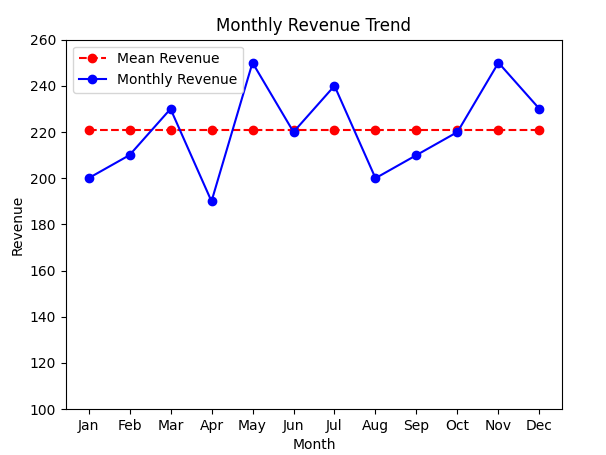

## 思考

能否让大模型直接输出代码，然后执行代码，返回结果？

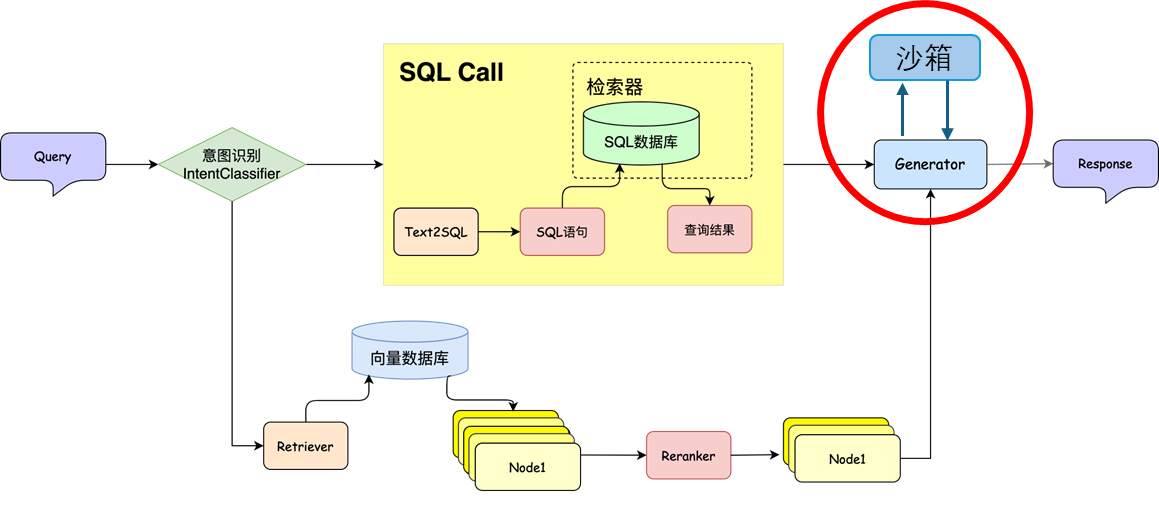

**大模型输出代码，在沙箱中执行？**

📊 整体流程是：用户提出问题后，通过意图识别后，系统首先使用 Text2SQL 工具将自然语言转化为对应的 SQL 语句并执行查询；接着将查询结果交给大语言模型（LLM）处理，并通过**Code Interpret**，使得模型能够**生成绘图代码**，然后在沙箱中执行代码生成相应图表。这样，系统就能实现数据分析与可视化的一体化输出。

## 总结

通过整合 Text2SQL 和 FunctionCall，不仅能够自动化生成查询语句并执行复杂的数据分析，还能有效提升分析过程的效率和准确性。其中，Text2SQL 技术使得用户能够用自然语言直接提问，系统自动将其转化为 SQL 查询语句。这大大降低了用户与数据库交互的门槛，使非技术背景的用户也能够通过自然语言实现数据查询。而Function Call 提供了一个自动化执行工具调用的机制，使系统可以在提取的数据上进行复杂的数学计算或图表绘制，使数据分析不仅限于提取数据，还可以进行深度分析和推理，甚至可以对不同数据集进行比较和可视化，进一步洞察数据背后的趋势和规律。

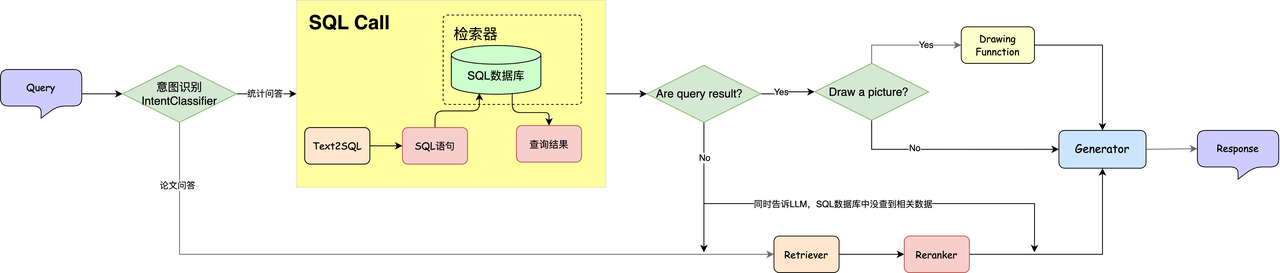

通过结合 Text2SQL 和 FunctionCall，RAG 系统可以在无需人工干预的情况下，实现从数据获取到统计分析的一体化过程。在实战课中，我们将实现如上图所示的工作流，实现一个既能回答统计问题，又能回答论文问答问题的系统。



